# Create Norway elevation map + MEPS area using Etopo1 and matplotlib
http://www.trondkristiansen.com/?page_id=846


https://www.ngdc.noaa.gov/mgg/global/global.html

In [23]:
import numpy as np
import os, sys, datetime, string
sys.path.append('/Volumes/SANDISK128/Documents/Schirle_Cooper_etal[2018]/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Schirle_Cooper_etal[2018]/Python/MEPS/')
sys.path.append('/Volumes/SANDISK128/Documents/Research_UiO_50/Python/windrose/')
from windrose import WindroseAxes

import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.basemap import Basemap
import netCDF4
import matplotlib as mpl
import save_fig as sF
import createFolder as cF
from calc_station_properties import find_station_yx



In [2]:
import matplotlib.colors as colors

import gdal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
import pandas as pd
from matplotlib.colors import LightSource
from pyproj import Proj, transform

In [3]:
savefig = 0   # 1 = yes, 0 = no
if savefig == 1:
    fig_dir = '../../Figures/Norway_map'
    cF.createFolder(fig_dir)
form = 'png'

In [4]:
def Lambert_map(lllon, lllat, urlon, urlat, lat0, lon0, res='l', fill=False, zoom=False):
    """lllon - lon lower left corner ...
    lat0 - latitude standard parallel, should be somewhere in the center of the domain
    lon0 - the parallel longitude
    lllon - lower left longitude ...
    http://matplotlib.org/basemap/api/basemap_api.html"""
    rsphere=(6378137.00,6356752.3142)
    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
            resolution=res,area_thresh=1000.,projection='lcc', lat_0=lat0,lon_0=lon0)
#    map = Basemap(llcrnrlon=lllon, llcrnrlat=lllat, urcrnrlon=urlon, urcrnrlat=urlat, rsphere=rsphere,
 #           resolution=res,area_thresh=1000.,projection='lcc', lat_1=lllon,lon_0=lon0)
    # Draw the latitudes and the longitudes
#    parallels = np.arange(0.,90,5.)
 #   map.drawparallels(parallels,labels=[True,False,False,False],fontsize=16)    
  #  meridians = np.arange(10.,361.,10.)
   # map.drawmeridians(meridians,labels=[False,False,False,True],fontsize=16)
    if zoom == False:
        map.drawmeridians(np.arange(0,90,10),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(10,361,4),labels=[1,0,0,0],fontsize=16)
    else:
#        map.drawmeridians(np.arange(0,90,3),labels=[0,0,0,1],fontsize=16)
 #       map.drawparallels(np.arange(0,361,2),labels=[1,0,0,0],fontsize=16)
        map.drawmeridians(np.arange(0,90,0.1),labels=[0,0,0,1],fontsize=16)
        map.drawparallels(np.arange(0,361,0.05),labels=[1,0,0,0],fontsize=16)

    # Draw the coastline
    map.drawcoastlines()#color='0.5')
    
    

    if fill:
        map.drawlsmask(#land_color='0.8', 
            ocean_color='gainsboro')
    
#    if zoom == False:
    
    ### plot MEPS area
 #       for i in range(0,lato.shape[0],12):
  #          xs, ys = map(lono[i], lato[i])
   #         map.plot(xs,ys, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)
    #    for i in range(0,lato2.shape[0],12):
     #       xs2, ys2 = map(lono2[i], lato2[i])
      #      map.plot(xs2,ys2, color = 'orange', marker = 'o', markersize = 10, linestyle = '-', linewidth = 10)

       # xs, ys = map(lono[739], lato[739])
        #map.plot(xs,ys, color = 'orange', marker ='o', markersize = 10, linestyle = '-', linewidth = 10, label = 'MEPS domain')
        #lgd = plt.legend(loc='lower left',fontsize=18)

    #map.drawmapboundary(fill_color='gainsboro')
        
    return map    



In [5]:
def PlotContours(Lon, Lat, psurf, map, nrlevels=10, leveldist=None,levels=None, numbers=True, color= 'k'):
    """ contours for example the pressure
    nrlevels - gives the number of displayed levels
    leveldist - gives distance between levels, if specified the nlevels is ignored
    levels - can be an array that specifies the levels to display, if specified nrlevels and leveldist are ignored
    numbers - True if the contours are labeled
    color - color of the contours (None is s color map)"""
    if levels is not None:
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)
    elif leveldist is not None:
        levels= np.arange(np.round(np.min(psurf)- np.min(psurf)%leveldist), np.round(np.max(psurf)+ leveldist), leveldist)
        cs= map.contour(Lon, Lat, psurf, levels, linewidths= 1. , colors= color)        
    else:
        cs= map.contour(Lon, Lat, psurf, nrlevels, linewidths= 1. , colors= color)#, colors= 6*['b']+ 6*['r'],)
    if numbers == True: plt.clabel(cs, fontsize=10, inline=1, fmt='%1.0f', color= 'black')
    #plt.tight_layout()

In [6]:
def PlotColorMap4(Lon, Lat, data, map, maxlevel= None, symetric=True, bounds=None, label='', color= 'RdBu', boxnr= 21):
    """ plot a color map, e.g. vertical velocity
    if symetric == True it is symetric around 0 and the maxlevel is calculated automatically
    best version of PlotColorMap"""
    
    if color== 'RdBu': colors= [(plt.cm.RdBu_r(h)) for h in range(256)]
    elif color== 'seismic': colors= [(plt.cm.seismic(h)) for h in range(256)]
    elif color== 'blue': colors= [(plt.cm.Blues(h)) for h in range(256)]
    elif color== 'inverse_blue': colors= [(plt.cm.Blues(h)) for h in range(255, 0, -1)]

    elif color == 'red': colors= ['azure']+[(plt.cm.Reds(h)) for h in range(256)]
    else: print('wrong color')
#    if bounds != None: boxnr = len(bounds)
    new_map = plt.matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors) #, N=boxnr)

    if bounds is None:
        if maxlevel is not None: minlevel= maxlevel
        if maxlevel is None and bounds is None:
            if symetric is True:
                maxlevel, minlevel= np.max(np.abs(data)), -np.max(np.abs(data))
            else:
                maxlevel, minlevel= np.max(data), np.min(data)       
        
        bounds= np.round(np.linspace(minlevel, maxlevel, boxnr+1), int(np.log10(85/maxlevel)))
#        bounds= np.round(list(np.linspace(-maxlevel, 0, boxnr//2+1))+list(np.linspace(0, maxlevel, boxnr//2+1)), int(np.log10(85/maxlevel)))        
#        print(maxlevel)

    Lon= 0.5* (Lon[1:, 1:]+ Lon[:-1, :-1])
    Lat= 0.5* (Lat[1:, 1:]+ Lat[:-1, :-1])
        
    norm= mpl.colors.BoundaryNorm(bounds, new_map.N)
    cs= map.pcolormesh(Lon, Lat, data[1:, 1:], norm= norm, cmap=new_map, alpha= 1.)
    cb = map.colorbar(cs, boundaries= bounds, norm= norm, location='right',pad='3%',extend='max')
        
    cb.set_label(label, size=18)    
    cb.ax.tick_params(labelsize=16)



In [7]:
#### Plot kartverket elevation ###
champ = 255.
no0 = np.array([0,155,88])/champ    #700
no1 = np.array([0,160,79])/champ    #750
no2 = np.array([0,164,72])/champ    #800
no3 = np.array([55,168,76])/champ    #850
no4 = np.array([81,171,79])/champ    #900
no5 = np.array([104,174,82])/champ    #950
no6 = np.array([119,177,84])/champ    #1000
no7 = np.array([136,180,85])/champ    #1050
no8 = np.array([151,183,87])/champ    #1100
no9 = np.array([165,185,88])/champ    #1150
no10 = np.array([179,187,89])/champ    #1200
no11 = np.array([185,180,92])/champ    #1250
no12 = np.array([190,173,94])/champ    #1300
no13 = np.array([197,164,98])/champ    #1350
no14 = np.array([205,168,117])/champ    #1400
no15 = np.array([214,173,134])/champ    #1450
no16 = np.array([223,180,154])/champ    #1500
no17 = np.array([231,190,174])/champ    #1550
no18 = np.array([239,204,195])/champ    #1600
no19 = np.array([246,221,220])/champ    #1650
no20 = np.array([252,241,242])/champ    #1700
no21 = np.array([255,255,255])/champ    #1750

no22 = np.array([80,80,81])/champ

In [17]:
#url = ('http://thredds.met.no/thredds/dodsC/meps25epsarchive/2016/12/24/meps_mbr0_pp_2_5km_20161224T12Z.nc')
url = ('http://thredds.met.no/thredds/dodsC/meps25epsarchive/2016/12/23/meps_mbr0_pp_2_5km_20161223T00Z.nc')
#url = ('http://thredds.met.no/thredds/dodsC/meps25epsarchive/2016/12/21/meps_mbr0_pp_2_5km_20161221T00Z.nc')
dataset = netCDF4.Dataset(url)

land= dataset.variables['land_area_fraction'][:]
lonpp= dataset.variables['longitude'][:]
latpp= dataset.variables['latitude'][:]

#x_wind = dataset.variables['x_wind_10m'][14,:,:]
#y_wind = dataset.variables['y_wind_10m'][14,:,:]

#T_2m= dataset.variables['air_temperature_2m'][:]
alti= dataset.variables['altitude'][:]


dataset.close()

### Norgeskart

In [11]:
gdal_data = gdal.Open('6600_1_10m_z33.tif')
gt = gdal_data.GetGeoTransform()

gdal_band = gdal_data.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

# convert to a numpy array
data_array = gdal_data.ReadAsArray().astype(np.float)
data_array

# replace missing values if necessary
if np.any(data_array == nodataval):
    data_array[data_array == nodataval] = np.nan

In [12]:
gdal_data2 = gdal.Open('6600_2_10m_z33.tif')
gt2 = gdal_data2.GetGeoTransform()

gdal_band2 = gdal_data2.GetRasterBand(1)
nodataval2 = gdal_band2.GetNoDataValue()

# convert to a numpy array
data_array2 = gdal_data2.ReadAsArray().astype(np.float)
data_array2

# replace missing values if necessary
if np.any(data_array2 == nodataval):
    data_array2[data_array2 == nodataval] = np.nan

In [13]:
gdal_data3 = gdal.Open('6600_3_10m_z33.tif')
gt3 = gdal_data3.GetGeoTransform()

gdal_band3 = gdal_data3.GetRasterBand(1)
nodataval3 = gdal_band3.GetNoDataValue()

# convert to a numpy array
data_array3 = gdal_data3.ReadAsArray().astype(np.float)
data_array3

# replace missing values if necessary
if np.any(data_array3 == nodataval):
    data_array3[data_array3 == nodataval] = np.nan

In [14]:
gdal_data4 = gdal.Open('6600_4_10m_z33.tif')
gt4 = gdal_data4.GetGeoTransform()

gdal_band4 = gdal_data4.GetRasterBand(1)
nodataval4 = gdal_band4.GetNoDataValue()

# convert to a numpy array
data_array4 = gdal_data4.ReadAsArray().astype(np.float)
data_array4

# replace missing values if necessary
if np.any(data_array4 == nodataval):
    data_array4[data_array4 == nodataval] = np.nan

In [15]:
xres = gt[1]
yres = gt[5]
x = np.arange(gt[0], gt[0] + data_array.shape[1]*xres, xres)
y = np.arange(gt[3], gt[3] + data_array.shape[0]*yres, yres)
X, Y = np.meshgrid(x,y)

xres2 = gt2[1]
yres2 = gt2[5]
x2 = np.arange(gt2[0], gt2[0] + data_array2.shape[1]*xres2, xres2)
y2 = np.arange(gt2[3], gt2[3] + data_array2.shape[0]*yres2, yres2)
X2, Y2 = np.meshgrid(x2,y2)

xres3 = gt3[1]
yres3 = gt3[5]
x3 = np.arange(gt3[0], gt3[0] + data_array3.shape[1]*xres3, xres3)
y3 = np.arange(gt3[3], gt3[3] + data_array3.shape[0]*yres3, yres3)
X3, Y3 = np.meshgrid(x3,y3)

xres4 = gt4[1]
yres4 = gt4[5]
x4 = np.arange(gt4[0], gt4[0] + data_array4.shape[1]*xres4, xres4)
y4 = np.arange(gt4[3], gt4[3] + data_array4.shape[0]*yres4, yres4)
X4, Y4 = np.meshgrid(x4,y4)




In [35]:
inProj = Proj(init='EPSG:32633')          # UTM coords, zone 33N, WGS84 datum
outProj = Proj(init='EPSG:4326')          # LatLon with WGS84 datum used by GPS units and Google Earth
lon1,lat1 = X,Y
LONO1,LATO1 = transform(inProj,outProj,lon1,lat1)
#
lon2,lat2 = X2,Y2
LONO2,LATO2 = transform(inProj,outProj,lon2,lat2)
#
lon3,lat3 = X3,Y3
LONO3,LATO3 = transform(inProj,outProj,lon3,lat3)
#
lon4,lat4 = X4,Y4
LONO4,LATO4 = transform(inProj,outProj,lon4,lat4)



#### Plot around Haukeliseter ####
fig = plt.figure(figsize=(10,9))
plt.clf()
#map = Lambert_map(lllon=lon2.min(), lllat=lat2.min(), 
 #                 urlon=lon2.max(), urlat=lat2.max(), 
  #                lat0= 63.5, lon0= 15, res='i', fill=False,zoom=True)

#map= Lambert_map(lllon=7.05, lllat=59.73, urlon=7.35, urlat=59.91, lat0= 63.5, lon0= 15, res='i', fill=False,zoom=True)
map= Lambert_map(lllon=6.85, lllat=59.67, urlon=7.45, urlat=59.97, lat0= 63.5, lon0= 15, res='i', fill=False,zoom=True)
LON1,LAT1 = map(LONO1,LATO1)
LON2,LAT2 = map(LONO2,LATO2)
LON3,LAT3 = map(LONO3,LATO3)
LON4,LAT4 = map(LONO4,LATO4)

#cmap = colors.ListedColormap([no0, no1, no2, no3, no4, no5, no6, no7, no8, no9, no10, \
 #                             no11, no12, no13, no14, no15, no16, no17, no18, no19, no20, \
  #                           no21])
levels = np.arange(700,1800,50)




PlotContours(LON1, LAT1, data_array, map, leveldist=None,levels=levels[::2], numbers=True, color= 'gray')
PlotContours(LON2, LAT2, data_array2, map, leveldist=None,levels=levels[::2], numbers=True, color= 'gray')
PlotContours(LON3, LAT3, data_array3, map, leveldist=None,levels=levels[::2], numbers=True, color= 'gray')
PlotContours(LON4, LAT4, data_array4, map, leveldist=None,levels=levels[::2], numbers=True, color= 'gray')


#norm = colors.BoundaryNorm(boundaries = levels, ncolors=cmap.N)
levels = np.arange(0,np.nanmax(alti),50)
norm = colors.BoundaryNorm(boundaries = levels, ncolors=plt.cm.gist_earth.N)
#cs = map.contourf(LON1, LAT1, data_array, levels, norm=norm, cmap = cmap, extend='max')
#map.contourf(LON2, LAT2, data_array2, levels, norm=norm, cmap=cmap, extend='max')
#map.contourf(LON3, LAT3, data_array3, levels, norm=norm, cmap=cmap, extend='max')
#map.contourf(LON4, LAT4, data_array4, levels, norm=norm, cmap=cmap, extend='max')
cs = map.contourf(LON1, LAT1, data_array, levels, norm=norm, cmap = plt.cm.gist_earth, extend='max')
map.contourf(LON2, LAT2, data_array2, levels, norm=norm, cmap=plt.cm.gist_earth, extend='max')
map.contourf(LON3, LAT3, data_array3, levels, norm=norm, cmap=plt.cm.gist_earth, extend='max')
map.contourf(LON4, LAT4, data_array4, levels, norm=norm, cmap=plt.cm.gist_earth, extend='max')


cb = plt.colorbar(cs, boundaries= levels, #location='right',
                  extend='max')
        
cb.set_label('Altitude [m]', size=18)    
cb.ax.tick_params(labelsize=16)
plt.gca().set_aspect('equal', adjustable='box')

cb.ax.set_xticklabels([700, '', '', '', 900,'','','',1100,'','','',1300,'','','',1500,
                        '','','',1700,''])  # horizontal colorbar

#namestat = ['Haukeliseter (991 m a.s.l.)']#, 'lower left', 'upper right']#,'grid point']
lonstat = [7+12.87/60]#,7.05, 7.4]#,7.2]
latstat= [59+48.73/60]#,59.65, 59.9]#,59.8]


xpt, ypt= map(lonstat, latstat)
map.plot(xpt,ypt,'ko', markersize=7)
ax1=fig.add_axes( [xpt, ypt, 1000, 1000] , projection='lambert')
ax0 = WindroseAxes.from_ax(ax1)
ax0.bar(  eklima_wind_dir_10m[np.logical_and(~np.isnan(eklima_double_fence_acc[:,:]), 
                                                       eklima_double_fence_acc[:,:] >= 0.0)], 
        eklima_wind_speed_10m[np.logical_and(~np.isnan(eklima_double_fence_acc[:,:]), 
                                                       eklima_double_fence_acc[:,:] >= 0.0)], 
       normed=True, opening=0.8, edgecolor ='white',cmap=cmap, bins = np.arange(0,24,4))


#for i in range(len(namestat)):
 #   plt.text(xpt[i], ypt[i], namestat[i], fontsize=18,fontweight='bold', ha='center',va='bottom',color='black')

fig_name = 'elevation_Haukeli.png'
if savefig == 1:
    sF.save_figure_portrait(fig_dir,fig_name,form)
    print('saved: %s/%s' %(fig_dir,fig_name))
else:
    plt.show()
plt.close()

TypeError: unhashable type: 'list'

In [20]:
m = ['11', '12', '01', '02', '03']

In [21]:
## load all necessary days and create an array for
# - double fence accumulation
# - 10m wind 

eklima_double_fence_acc = []
eklima_wind_dir_10m = []
eklima_wind_speed_10m = []
for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    eklima_f = dict()
    
    tid = dict()
    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        eklima_dirnc = '../../Data/Eklima/Haukeliseter/precip_wind_temp_%s%s%s.nc' %(year,month,day)
        
        eklima_f[int(year+month+day)] = netCDF4.Dataset(eklima_dirnc, 'r')
        eklima_double_fence_acc.append(eklima_f[int(year+month+day)].variables['RR_1'][:])

        eklima_wind_dir_10m.append(eklima_f[int(year+month+day)].variables['DD'][:])
    #    tid[int(year+month+day)] = np.arange(wind_dir_10m.shape[0])

        eklima_wind_speed_10m.append(eklima_f[int(year+month+day)].variables['FF'][:])
        
        eklima_f[int(year+month+day)].close

eklima_double_fence_acc = np.array(eklima_double_fence_acc)
eklima_wind_dir_10m     = np.array(eklima_wind_dir_10m)
eklima_wind_speed_10m   = np.array(eklima_wind_speed_10m)

/Volumes/SANDISK128/Applications/anaconda/envs/py36wind/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Volumes/SANDISK128/Applications/anaconda/envs/py36wind/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


In [22]:
#viridis = plt.get_cmap('viridis')
champ = 255.
no1 = np.array([79,94,26])/champ
no2 = np.array([131,156,45])/champ
no3 = np.array([71,153,112])/champ
no4 = np.array([77,111,157])/champ
no5 = np.array([157,58,55])/champ
no6 = np.array([211,120,50])/champ
no7 = np.array([218,181,70])/champ

cmap = colors.ListedColormap([no1, no2, no3, no4, no5, no6, no7])

/Volumes/SANDISK128/Applications/anaconda/envs/py36wind/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/Volumes/SANDISK128/Applications/anaconda/envs/py36wind/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


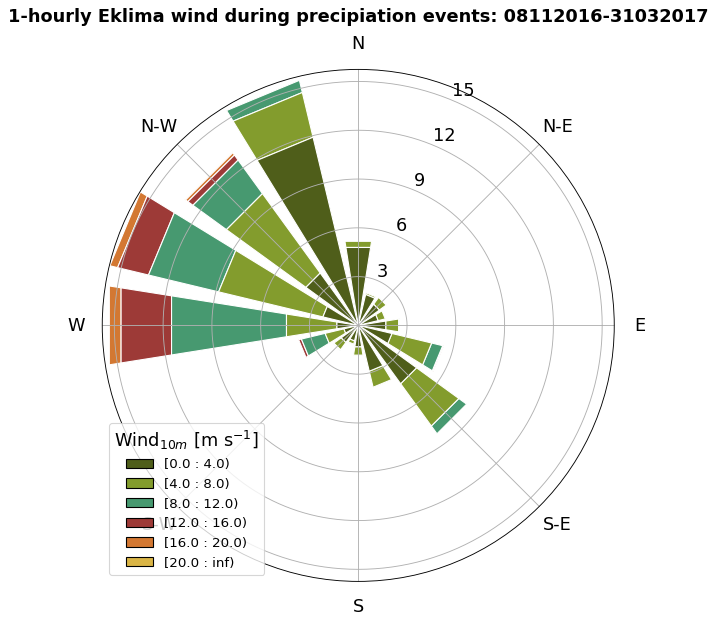

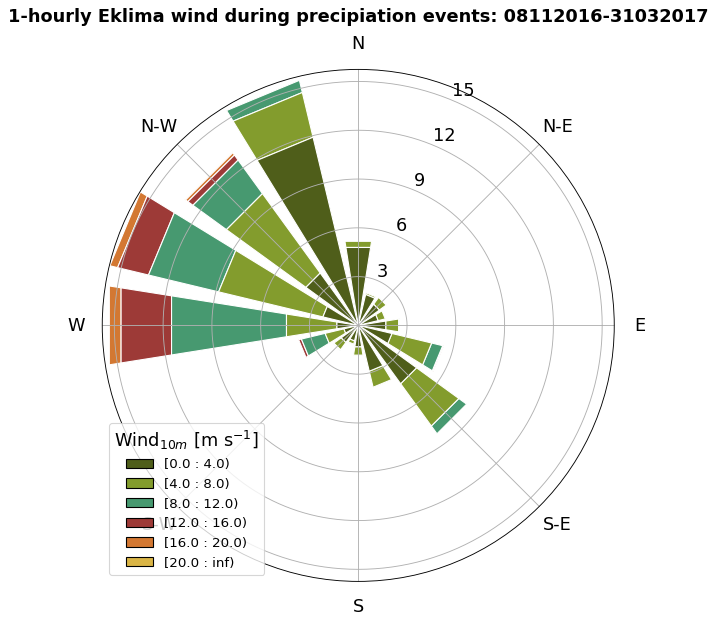

In [25]:
ax0 = WindroseAxes.from_ax()
ax0.bar(  eklima_wind_dir_10m[np.logical_and(~np.isnan(eklima_double_fence_acc[:,:]), 
                                                       eklima_double_fence_acc[:,:] >= 0.0)], 
        eklima_wind_speed_10m[np.logical_and(~np.isnan(eklima_double_fence_acc[:,:]), 
                                                       eklima_double_fence_acc[:,:] >= 0.0)], 
       normed=True, opening=0.8, edgecolor ='white',cmap=cmap, bins = np.arange(0,24,4))
ax0._info['bins']
ax0.set_legend()
ax0.legend(title = 'Wind$_{10m}$ [m s$^{-1}$]', fontsize = 12)
ax0.get_legend().get_title().set_fontsize(16)
ax0.tick_params(labelsize = 16)
ax0.set_yticks(np.arange(3, 18, step=3))
ax0.set_yticklabels(np.arange(3, 18, step=3))
ax0.set_title('1-hourly Eklima wind during precipiation events: 08112016-31032017', fontsize = 16, y=1.08,fontweight='bold')
if savefig == 1:
    fig_name = 'eklima_wind_precip_events_2016_2017.%s' %form
    cF.createFolder('%s/' %(figdir))
    plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight', transparent=True)
    print('plot saved: %s/%s' %(figdir,fig_name))
else:
    plt.show()